In [19]:
import modin.pandas as mipd
import os
import time
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


In [20]:
time_resolution = 30
time_window = 10
lk_path = '/mnt/data0/lkyin/'
c_path = './data_smoothed'+str(time_resolution+time_window)+'/commits/'
e_path = './data_smoothed'+str(time_resolution+time_window)+'/emails/'
mix_path = './data_smoothed'+str(time_resolution+time_window)+'/mix/'

## Technique Network

+ View the Dataset here, read from the saved csv
++ Route('/mnt/data0/lkyin/network_data/emails/')

## ASF Techinical Network Construction from Likang
+ Using NetworkX for analysis
    + https://www.osgeo.cn/networkx/tutorial.html#attributes

    + Use Pandas with NetworkX https://www.jianshu.com/p/11456474d8a5

+ How this network is constructed (Data already saved as commits for each project each month):
    + Tow features: "is_bot" as False and "is_coding" as True
    + Author is not null (SVN has 'noauthor')
    + For each row:
        + Check if file name exist as node
        + Add file as Node
        + Edges saved in technical_net as a set
        + for each commit on each file, weight +1
    + Use technical_net to construct graph
        + Network attributes from the dictionary: https://www.osgeo.cn/networkx/tutorial.html#attributes

In [21]:
projects = os.listdir(c_path)
projects.sort(key= lambda x:int(x.split('__')[1].split('.')[0]))
to_path = './network_data_smoothed'+str(time_resolution+time_window)+'/commits/'
if not os.path.exists(to_path):
    os.makedirs(to_path)
gx_technets = []
for project in tqdm(projects):
    technical_net = {}
    project_name, period = project.replace('.csv', '').split('__')
    fname = project
    if not os.path.exists(c_path+fname):
        continue
    df = pd.read_csv(c_path+fname)
    df.query('is_bot == False and is_coding == True', inplace=True)
    df = df[df['dealised_author_full_name'].notna()]
    for index, row in df.iterrows():
        file_path = row['file_name']
        # file extension = '.' + file_path.split('/')[-1].split('.')[-1].split(' ')[0]
        file_name = file_path.split('/')[-1]
        author_name = row['dealised_author_full_name']
        if file_name not in technical_net:
            technical_net[file_name] = {}
        if author_name not in technical_net[file_name]:
            technical_net[file_name][author_name] = {}
            technical_net[file_name][author_name]['weight'] = 0
        technical_net[file_name][author_name]['weight'] += 1

    #save as directed graph
    g = nx.DiGraph(technical_net)
    # add disconnected nodes
    g.add_nodes_from(technical_net.keys())
    nx.write_edgelist(g, to_path + '{}__{}.edgelist'.format(project_name, str(period)), delimiter='##', data=["weight"])
    gx_technets.append(g)

100%|██████████| 3960/3960 [05:57<00:00, 11.09it/s] 


In [22]:
technical_net

{'InitialsAvatarsServlet.java': {'Evan Hughes': {'weight': 2}}}

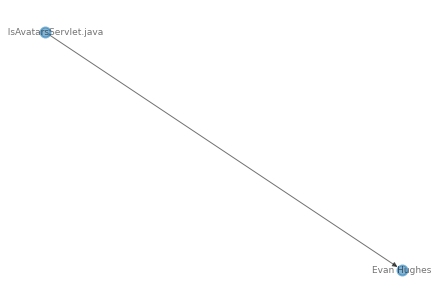

In [23]:
#nx.draw(g, with_labels=True, font_weight='bold')
nx.draw(g,
    with_labels=True,
    #pos = nx.sprint_layout(g),
    #node_color=color_list,
    edge_color='k',
    node_size=100,
    node_shape='o',
    linewidths=2,
    width=1.0,
    alpha=0.55,
    style='solid',
    font_size=9,
    font_color='k'
)

## ASF Social Networks Construction From Likang

+ How this network is constructed (Data already saved as commits for each project each month):
    + Tow features: "is_bot" as False and "is_coding" as True
    + Author is not null
    + For each email:
        + Check if this email have previous references, if not, quit and go next
        + Add previous authors as Nodes
        + Edges saved in social_net as a node
        + for each email sent to previous edges on each file, mutually (sender to previous & previous to sender) weight +1

In [24]:
to_path = './network_data_smoothed'+str(time_resolution+time_window)+'/emails/'
if not os.path.exists(to_path):
    os.makedirs(to_path)

projects = os.listdir(e_path)
projects.sort(key= lambda x:int(x.split('__')[1].split('.')[0]))
gx_socialnets = []
for project in tqdm(projects):

    social_net = {}
    emailID_to_author = {}
    project_name, period = project.replace('.csv', '').split('__')
    fname = project
    if not os.path.exists(e_path+fname):
        continue
    df = pd.read_csv(e_path+fname)
    df.query('is_bot == False', inplace=True)
    df = df[df['dealised_author_full_name'].notna()]
    
    for index, row in df.iterrows():
        message_id = row['message_id'].strip()
        # print(row['dealised_author_full_name'])
        sender_name = row['dealised_author_full_name']
        emailID_to_author[message_id] = sender_name

    # raise KeyError
    for index, row in df.iterrows():
        message_id = row['message_id']
        references = row['references']
        sender_name = row['dealised_author_full_name']

        # ignores if this email does not to previous emails
        if pd.isna(references) or references == 'None':
            continue

        references = [r.strip() for r in references.replace('\n', ' ').replace('\t', ' ').split(' ') if r.strip()]

        # deal with the issue that a line breaker exists in message_id:
        # e.g., <4\n829AB62.6000302@apache.org>
        new_refs = set()
        for i in range(len(references)-1):
            if '<' in references[i] and '>' not in references[i] and '<' not in references[i+1] and '>' in references[i+1]:
                new_refs.add(references[i] + references[i+1])
        for r in references:
            if '<' in r and '>' in r:
                new_refs.add(r)

        references = new_refs
        for reference_id in references:
            if reference_id not in emailID_to_author:
                continue
            prev_author = emailID_to_author[reference_id]
            # if it's the same person, continue
            if prev_author == sender_name:
                continue
            if sender_name not in social_net:
                social_net[sender_name] = {}
            if prev_author not in social_net:
                social_net[prev_author] = {}

            # if node B replies node A, it means B sends signal to A
            if prev_author not in social_net[sender_name]:
                social_net[sender_name][prev_author] = {}
                social_net[sender_name][prev_author]['weight'] = 0
            social_net[sender_name][prev_author]['weight'] += 1

            # if node B replies node A, it means A also sent signal to B
            if sender_name not in social_net[prev_author]:
                social_net[prev_author][sender_name] = {}
                social_net[prev_author][sender_name]['weight'] = 0
            social_net[prev_author][sender_name]['weight'] += 1

    #save as directed graph
    g = nx.DiGraph(social_net)
    # add disconnected nodes
    g.add_nodes_from(social_net.keys())
    nx.write_edgelist(g, to_path + '{}__{}.edgelist'.format(project_name, str(period)), delimiter='##', data=["weight"])
    gx_socialnets.append(g)

100%|██████████| 4713/4713 [03:35<00:00, 21.92it/s] 


In [25]:
projects.sort(key= lambda x:int(x.split('__')[1].split('.')[0]))
projects

['atlas__001.csv',
 'kafka__001.csv',
 'jackrabbit__001.csv',
 'juneau__001.csv',
 's2graph__001.csv',
 'sentry__001.csv',
 'libcloud__001.csv',
 'druid__001.csv',
 'provisionr__001.csv',
 'shardingsphere__001.csv',
 'flex__001.csv',
 'felix__001.csv',
 'flume__001.csv',
 'click__001.csv',
 'lenya__001.csv',
 'knox__001.csv',
 'cotton__001.csv',
 'olio__001.csv',
 'spark__001.csv',
 'hise__001.csv',
 'ofbiz__001.csv',
 'datafu__001.csv',
 'ode__001.csv',
 'subversion__001.csv',
 'oodt__001.csv',
 'pulsar__001.csv',
 'openmeetings__001.csv',
 'falcon__001.csv',
 'tashi__001.csv',
 'lens__001.csv',
 'helix__001.csv',
 'cassandra__001.csv',
 'etch__001.csv',
 'shiro__001.csv',
 'storm__001.csv',
 'oozie__001.csv',
 'ranger__001.csv',
 'depot__001.csv',
 'johnzon__001.csv',
 'jclouds__001.csv',
 'dolphinscheduler__001.csv',
 'streams__001.csv',
 'tika__001.csv',
 'superset__001.csv',
 'empire__001.csv',
 'daffodil__001.csv',
 'vxquery__001.csv',
 'concerted__001.csv',
 'stdcxx__001.csv',
 

In [26]:
social_net

{'David Fisher': {'Svante Schubert': {'weight': 2}},
 'Svante Schubert': {'David Fisher': {'weight': 2}}}

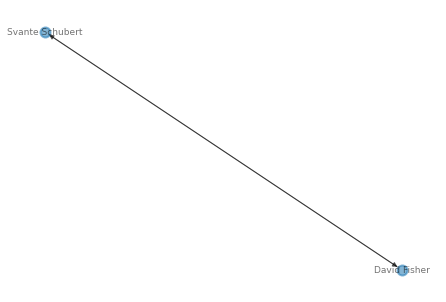

In [27]:
#nx.draw(g, with_labels=True, font_weight='bold')
nx.draw(g,
    with_labels=True,
    #pos = nx.sprint_layout(g),
    #node_color=color_list,
    edge_color='k',
    node_size=100,
    node_shape='o',
    linewidths=2,
    width=1.0,
    alpha=0.55,
    style='solid',
    font_size=9,
    font_color='k'
)